In [1]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [2]:
#import models.qp as model # import get_stocks # 1/PBR + GP/A
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
import models.lu_zhang as model

importlib.reload(model)

<module 'models.lu_zhang' from '/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/quantitative-value/models/lu_zhang.py'>

In [3]:
MODEL_NAME = 'qp'
DATA_DIR = '../data/daily/8-1'

In [4]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [5]:
df_account

,start_date,end_date,filepath
0,2000-08-01,2001-08-01,../data/daily/8-1/2000-08-01.csv
1,2001-08-01,2002-08-01,../data/daily/8-1/2001-08-01.csv
2,2002-08-01,2003-08-01,../data/daily/8-1/2002-08-01.csv
3,2003-08-01,2004-08-02,../data/daily/8-1/2003-08-01.csv
4,2004-08-02,2005-08-01,../data/daily/8-1/2004-08-02.csv
5,2005-08-01,2006-08-01,../data/daily/8-1/2005-08-01.csv
6,2006-08-01,2007-08-01,../data/daily/8-1/2006-08-01.csv
7,2007-08-01,2008-08-01,../data/daily/8-1/2007-08-01.csv
8,2008-08-01,2009-08-03,../data/daily/8-1/2008-08-01.csv
9,2009-08-03,2010-08-02,../data/daily/8-1/2009-08-03.csv


In [6]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

2000-08-01 선정 기업 수 30
2001-08-01 선정 기업 수 30
2002-08-01 선정 기업 수 30
2003-08-01 선정 기업 수 30
2004-08-02 선정 기업 수 30
2005-08-01 선정 기업 수 30
2006-08-01 선정 기업 수 30
2007-08-01 선정 기업 수 30
2008-08-01 선정 기업 수 30
2009-08-03 선정 기업 수 30
2010-08-02 선정 기업 수 30
2011-08-01 선정 기업 수 30
2012-08-01 선정 기업 수 30
2013-08-01 선정 기업 수 30
2014-08-01 선정 기업 수 30
2015-08-03 선정 기업 수 30
2016-08-01 선정 기업 수 30
2017-08-01 선정 기업 수 30
2018-08-01 선정 기업 수 30


In [7]:
# 백테스트 기간의 가격 정보를 가져온다.
df_price = marcap_data(df_account.iloc[0].start_date, df_account.iloc[len(df_account) - 1].end_date)

In [15]:
# 연도별 / 월별 수익률을 구한다.
df_account['monthly_yield'] = 0.0
df_account['monthly_yield'] = df_account['monthly_yield'].astype('object')
df_account['yearly_yield'] = 0.0
df_account['delisted_stocks'] = 0.0
df_account['delisted_stocks'] = df_account['delisted_stocks'].astype('object')
df_account['year_month'] = 0.0
df_account['year_month'] = df_account['year_month'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        stocks = df_account.iloc[i].stocks

        # 한 해의 가격 정보
        df_yearly_price = df_price[(df_price.index >= start_date) & (df_price.index < end_date)]
        
        # 연도-월
        df_year_month = df_yearly_price.groupby(df_yearly_price.index).agg({'Open': 'max'}).reset_index()
        df_year_month['year_month'] = df_year_month.apply(lambda x: str(x.Date)[:7], axis=1)
        df_year_month = df_year_month.groupby("year_month").agg({'Open': 'first'})

        # 종목별 월별 수익률 저장
        df_monthly_yield = pd.DataFrame()

        # 상폐 종목
        delisted_stocks = []
        
        # 종목별 월별 수익률 구하기
        for stock in stocks:
            df_yearly_stock_price = df_yearly_price[df_yearly_price.Code == stock].reset_index()
            if len(df_yearly_stock_price) == 0:
                df_monthly_yield[stock] = [0] * 12
                continue
                
            # 월별 수익률
            df_monthly_stock = pd.DataFrame(index=df_year_month.index)
            df_monthly_stock['yield'] = 1.0 # 1년 내에 가격 정보가 없는 기간은 거래 정지 기간이라고 보고 수익률을 1.0으로 처리
            
            # 월별로 groupby
            df_yearly_stock_price['year_month'] = df_yearly_stock_price.apply(lambda x: str(x.Date)[:7], axis=1)
            df_monthly_stock_yield = df_yearly_stock_price.groupby("year_month").agg({'Open': 'first', 'Close': 'last'})

            # 월별 수익률 기록하기
            for idx, row in enumerate(df_monthly_stock_yield.iterrows()):
                if idx == len(df_monthly_stock_yield) - 1: # 마지막 월
                    df_monthly_stock.at[row[0], 'yield'] = row[1]['Close'] / row[1]['Open']
                else:
                    df_monthly_stock.at[row[0], 'yield'] = df_monthly_stock_yield.iloc[idx + 1]['Open'] / row[1]['Open']
            
            if df_monthly_stock.index[-1] != df_monthly_stock_yield.index[-1]: # 마지막 월이 서로 다를 때 => 상폐 처리
                # 상폐된 row index 구하기
                row_index = len(df_monthly_stock_yield)
                
                # 상폐된 시점에서부터 수익률을 0.0으로 처리
                for idx, row in enumerate(df_monthly_stock.iterrows()):
                    if idx < row_index:
                        continue
                    df_monthly_stock.at[row[0], 'yield'] = 0.0
                
                # 상폐 종목에 추가
                delisted_stocks.append(stock)
            
            monthly_yield = df_monthly_stock['yield'].cumprod().tolist()
            df_monthly_yield[stock] = monthly_yield
            
        df_monthly_yield['total'] = df_monthly_yield.mean(axis=1) 
        df_monthly_yield['prev_total'] = df_monthly_yield['total'].shift(1)
        df_monthly_yield['prev_total'] = df_monthly_yield['prev_total'].fillna(1.0)
        df_monthly_yield['monthly_yield'] = df_monthly_yield['total'] / df_monthly_yield['prev_total'] - 1.0
        
        # 연도-월
        df_account.at[i, 'year_month'] = df_year_month.index.tolist()
        # 월별 수익률
        df_account.at[i, 'monthly_yield'] = df_monthly_yield['monthly_yield'].tolist()
        # 연도별 수익률
        yearly_yield = df_monthly_yield.iloc[len(df_monthly_yield) - 1]['total']
        df_account.at[i, 'yearly_yield'] = yearly_yield
        # 상폐 종목
        df_account.at[i, 'delisted_stocks'] = delisted_stocks

        print(start_date, end_date, yearly_yield)

2000-08-01 2001-08-01 1.615354416187291
2001-08-01 2002-08-01 0.7643813439033601
2002-08-01 2003-08-01 0.832999348271389
2003-08-01 2004-08-02 0.8072871851200839
2004-08-02 2005-08-01 2.353758126726201
2005-08-01 2006-08-01 1.5135188704140536
2006-08-01 2007-08-01 1.9423791713357825
2007-08-01 2008-08-01 0.862023055331015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars


2008-08-01 2009-08-03 0.9952421990125938
2009-08-03 2010-08-02 1.4785608804146726
2010-08-02 2011-08-01 1.115230627669744
2011-08-01 2012-08-01 1.1884915964018405
2012-08-01 2013-08-01 1.3761619431379617
2013-08-01 2014-08-01 1.0421942199757597
2014-08-01 2015-08-03 1.4806650896013234
2015-08-03 2016-08-01 1.2125211988478946
2016-08-01 2017-08-01 1.0292130447171828
2017-08-01 2018-08-01 1.039676935935646
2018-08-01 2019-08-01 0.9864297141586704


In [16]:
# CAGR, 자산변화 구하기
df_account['cum_yield'] = df_account['yearly_yield'].cumprod()

df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['cum_yield'], 1/(i+1))
cagr = df_account.iloc[len(df_account) - 1]['cagr']

monthly_yields = []
for i in range(len(df_account)):
    monthly_yields.extend(df_account.iloc[i]['monthly_yield'])
cum_monthly_yield = np.cumprod(np.array(monthly_yields) + 1)

cagr_history = []
for i, val in enumerate(cum_monthly_yield.tolist()):
    year = (i + 1) / 12
    cagr_history.append(pow(val, 1 / year))

# 수익률 표준편차 구하기
filetered_monthly_yield = monthly_yields.copy()

# outlier 제거
filetered_monthly_yield.remove(max(filetered_monthly_yield))
filetered_monthly_yield.remove(min(filetered_monthly_yield))

std_monthly_yield =  statistics.stdev(filetered_monthly_yield)

# 월별 승률
monthly_win_rate = (sum([val > 0 for val in monthly_yields]) / len(monthly_yields)) * 100.0

# 상폐 종목 수
delisted_stocks = []
for row in df_account.iterrows():
    delisted_stocks.extend(row[1]['delisted_stocks'])
    
# 연도-월
year_months = []
for row in df_account.iterrows():
    year_months.extend(row[1]['year_month'])

In [17]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in cum_monthly_yield:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration

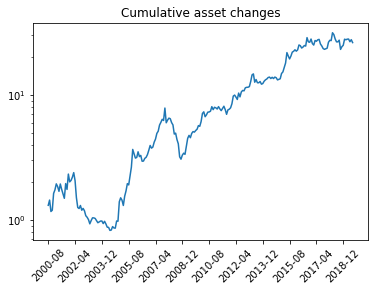

In [18]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(year_months, cum_monthly_yield)

loc = ticker.MultipleLocator(base=20.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45)

plt.title('Cumulative asset changes')
plt.show()

In [28]:
rolling_cagrs = []
ROLLING = 36
for i in range(len(cagr_history)):
    if i - ROLLING < 0:
        rolling_cagr = np.mean(cagr_history[0:i])
    else:
        rolling_cagr = np.mean(cagr_history[i - ROLLING:i])
    rolling_cagrs.append(rolling_cagr)

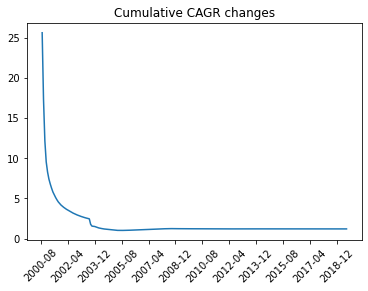

In [29]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.plot(year_months, rolling_cagrs, marker='', linestyle='-')

loc = ticker.MultipleLocator(base=20.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45)

plt.title('Cumulative CAGR changes')
plt.show()

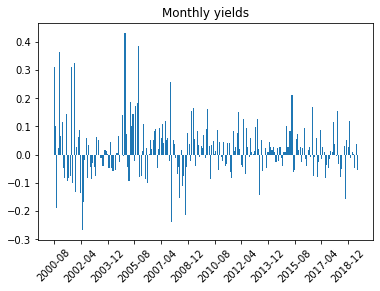

In [20]:
fig, ax = plt.subplots()
plt.bar(year_months, monthly_yields)
loc = ticker.MultipleLocator(base=20.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.xticks(rotation=45)
plt.title("Monthly yields")
plt.show()

In [21]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_monthly_yield,
           len(delisted_stocks),
           "%.2f%%" % monthly_win_rate,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+----------+----------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Note |
+-----------+--------+--------+--------------+--------+----------+----------+------+
|    8-1    | 18.77% | 65.51% |      14      | 0.0900 |    9     |  57.89%  |      |
+-----------+--------+--------+--------------+--------+----------+----------+------+
